# Exploratory Data Analysis

A variable dictionary can be found at https://s3.amazonaws.com/files.consumerfinance.gov/f/documents/cfpb_nfwbs-puf-codebook.pdf

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier

The output variable I am interested in is one's ability to handle an unexpected financial expense. Originally a 5-point ordinal variable, I encoded it as a Boolean variable 'target' that is True if the response was 4 or 5, indicating high confidence in one's ability to handle unexpected expenses. 

In [2]:
#Create dataframe df containing data and 'target' column 
df = pd.read_csv('NFWBS_PUF_2016_data.csv')

#Remove rows with nonsensical or uncertain responses  
mask1 = (df['HOUSERANGES'] < 98) & (df['VALUERANGES'] < 98) & (df['VALUERANGES'] > -1)
mask2 = (df['MORTGAGE'] < 98) & (df['MORTGAGE'] > -1) & (df['SAVINGSRANGES'] < 98)
mask3 = (df['SNAP'] < 8) & (df['ABSORBSHOCK'] < 8) & (df['FRAUD2'] < 8) 
df = df[mask1 & mask2 & mask3]

#True corresponds to confidence in ability to handle an unexpected financial expense
df['target'] = df['FWB1_1'] > 3

Because there were so many features in this data set (217, to be exact), I decided to use a random forest to act as an initial screen for what variables I would be exploring. I then selected what variables to explore on the basis of multicollinearity and some context/intuition. 

In [3]:
#Remove columns containing financial well being scores and other irrelevant/redundant columns or those with few responses
fwb_cols = [col for col in df if col.startswith('FWB')]
swb_cols = [col for col in df if col.startswith('SWB')]
kh_cols = [col for col in df if col.startswith('KHK')]
employ_cols = [col for col in df if col.startswith('EMPLOY1')]
single_cols = ['PUF_ID', 'finalwt', 'target', 'FSscore', 'PAIDHELP', 'HSLOC', 'RETIRE', 'SOCSEC2', 'SOCSEC3']
dfx = df.drop(fwb_cols + swb_cols + kh_cols + employ_cols + single_cols, axis=1)

#Convert relevant columns into categorical variables
cat_cols = ['HOUSING', 'LIVINGARRANGEMENT', 'AUTOMATED_1', 'AUTOMATED_2', 'COVERCOSTS', 'MANAGE2', 'EMPLOY']
pp_cols = [col for col in df if col.startswith('PP')]
for col in cat_cols + pp_cols:
    dfx[col] = dfx[col].astype('category')
    
#Create X and y values
X = dfx.values
y = df['target'].values

In [91]:
from sklearn.ensemble import RandomForestClassifier
 
#use logistic regression as the model
rf = RandomForestClassifier()
#rank all features, i.e continue the elimination until the last one
rf.fit(X,y)
 
idx = np.argsort(rf.feature_importances_)[::-1]

In [152]:
features = dfx.columns[idx]
for c, value in enumerate(features[:30]):
    print(c+1, value)

1 SAVINGSRANGES
2 ABSORBSHOCK
3 GOALCONF
4 ENDSMEET
5 FS1_6
6 SAVEHABIT
7 FS1_1
8 SUBKNOWL1
9 PRODHAVE_6
10 FS1_5
11 MANAGE1_3
12 FS1_2
13 agecat
14 CONNECT
15 PPINCIMP
16 ACT1_2
17 PEM
18 LIFEEXPECT
19 MANAGE1_2
20 KHscore
21 CHANGEABLE
22 FS1_7
23 SCFHORIZON
24 OUTLOOK_1
25 DISTRESS
26 FS1_4
27 SUBNUMERACY2
28 FS1_3
29 OUTLOOK_2
30 PAREDUC


We can see from the output above that some of the variables heavily associated with our target variable are the ability to raise $2,000 in 30 days, the frequency of paying off one's monthly credit card balance, financial knowledge, and age.

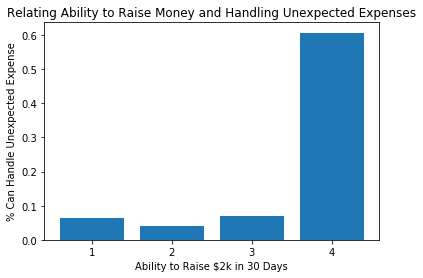

In [22]:
#Remove rows where response was 8 (corresponding to 'I don't know') or -1 (no response)
dfabsorb = df[(df['ABSORBSHOCK'] != 8) & (df['ABSORBSHOCK'] != -1)]

#Create table containing relevant values
absorb_tab = pd.crosstab(dfabsorb['ABSORBSHOCK'], dfabsorb['target'])

#Create x and y values to graph
x_vals = np.arange(4) + 1
x_labels = ['1', '2', '3', '4']
absorb_vals = np.empty(4)
for i in range(4):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    absorb_vals[i] = absorb_tab.loc[i+1, True] / np.sum(absorb_tab.iloc[i, 0:2])

#Create bar graph 
plt.bar(x_vals, absorb_vals)
plt.title('Relating Ability to Raise Money and Handling Unexpected Expenses')
plt.xlabel('Ability to Raise $2k in 30 Days')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

We can see that certainty in being able to raise $2,000 in 30 days causes a large spike of confidence in the ability to handle an unexpected expense, while certainly not being able to do so up to even probably being able to do so seem to inspire about equal levels of confidence. However, this relationship is quite obviously related to our target variable and serves as more of a sanity check. 

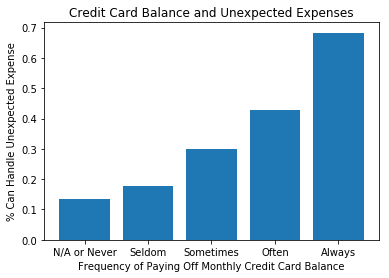

In [23]:
#Remove rows with no response
dfmanage = df[df['MANAGE1_3'] != -1]

#Create table with relevant values
manage_tab = pd.crosstab(dfmanage['MANAGE1_3'], dfmanage['target'])

#Create x and y values to graph
x_vals = np.arange(5) + 1
x_labels = ['N/A or Never', 'Seldom', 'Sometimes', 'Often', 'Always']
manage_vals = np.empty(5)
for i in range(5):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    manage_vals[i] = manage_tab.loc[i+1, True] / np.sum(manage_tab.iloc[i, 0:2])

#Create bar graph
plt.bar(x_vals, manage_vals)
plt.title('Credit Card Balance and Unexpected Expenses')
plt.xlabel('Frequency of Paying Off Monthly Credit Card Balance')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

We can see a more gradual effect in paying off one's credit card balance in full every month on one's confidence in their ability to handle unexpected financial expenses.

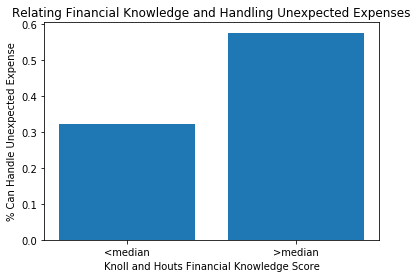

In [5]:
df['KHbinscore'] = df['KHscore'] > 0

#Create table with relevant values
khscore_tab = pd.crosstab(df['KHbinscore'], df['target'])

#Create x and y values to graph
x_vals = np.arange(2) + 1
x_labels = ['<median', '>median']
khscore_vals = np.empty(2)
for i in range(2):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    khscore_vals[i] = khscore_tab.iloc[i, 1] / np.sum(khscore_tab.iloc[i, 0:2])

#Create bar graph
plt.bar(x_vals, khscore_vals)
plt.title('Relating Financial Knowledge and Handling Unexpected Expenses')
plt.xlabel('Knoll and Houts Financial Knowledge Score')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

In [15]:
#Separate data by KH score
df_lowscore = df[df['KHbinscore'] == 0]
df_highscore = df[df['KHbinscore'] == 1]

#Calculate p-value using t test 
stat, p = ttest_ind(df_highscore['target'], df_lowscore['target'], equal_var=False)

print("p-value: {}".format(p))

p-value: 4.604376084147507e-38


After transforming our financial knowledge score into a binary variable, we can see that an above average score increases one's ability to an handle unexpected expense. About 30% more people with an above average score responded that they would be confident in such a situation than those with a below average score. A statistical analysis also supports the idea that this is a statistically significant difference.

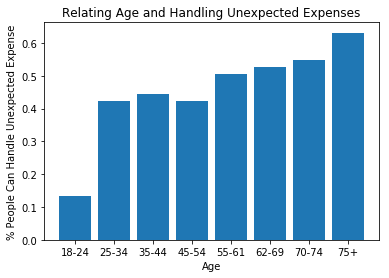

In [6]:
#Create table with relevant values
age_tab = pd.crosstab(df['agecat'], df['target'])

#Create x and y values to graph
x_vals = np.arange(8) + 1
x_labels = ['18-24', '25-34', '35-44', '45-54', '55-61', '62-69', '70-74', '75+']
age_vals = np.empty(8)
for i in range(8):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    age_vals[i] = age_tab.loc[i+1, True] / np.sum(age_tab.iloc[i, 0:2])

#Create bar graph
plt.bar(x_vals, age_vals)
plt.title('Relating Age and Handling Unexpected Expenses')
plt.xlabel('Age')
plt.ylabel('% People Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

We see that age does correlate with our target variable, although the change between age groups isn't too drastic. However, there is a large gap between the 18-24 group and older, meaning that the vast majority of young people are not able to absorb financial shocks. Let's tranform age into a binary variable to reflect this difference.

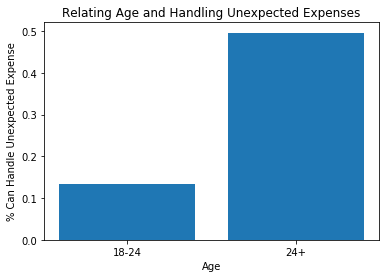

In [19]:
df['age_binary'] = df['agecat'] > 1

#Create table with relevant values
agebin_tab = pd.crosstab(df['age_binary'], df['target'])

#Create x and y values to graph
x_vals = np.arange(2) + 1
x_labels = ['18-24', '24+']
agebin_vals = np.empty(2)
for i in range(2):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    agebin_vals[i] = agebin_tab.iloc[i, 1] / np.sum(agebin_tab.iloc[i, 0:2])

#Create bar graph
plt.bar(x_vals, agebin_vals)
plt.title('Relating Age and Handling Unexpected Expenses')
plt.xlabel('Age')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

In [20]:
#Separate data by KH score
df_young = df[df['age_binary'] == 0]
df_old = df[df['age_binary'] == 1]

#Calculate p-value using t test 
stat, p = ttest_ind(df_young['target'], df_old['target'], equal_var=False)

print("p-value: {}".format(p))

p-value: 0.0013298017973604644


Let's use chi square analysis to check the significance of some of these results.

In [25]:
p_val = np.empty(2)

chi, p_val[0], dof, expected = chi2_contingency(absorb_tab)
chi, p_val[1], dof, expected = chi2_contingency(manage_tab)

for i in np.arange(2):
    print('p-val: {}'.format(p_val[i]))

p-val: 4.517230351275773e-117
p-val: 4.583986056068452e-115


Let's use VIF scores and a correlation matrix to remove variables that are highly correlated. 

In [28]:
#Only include features we want in our model
dfx_1 = df[['SAVINGSRANGES', 'ABSORBSHOCK', 'GOALCONF', 'ENDSMEET', 'FS1_6', 'SAVEHABIT', 'FS1_1', 'SUBKNOWL1', 
            'PRODHAVE_6', 'FS1_5', 'MANAGE1_3', 'FS1_2', 'agecat', 'CONNECT', 'PPINCIMP']]

#Create our X and y
X_1 = dfx_1.values
y = df['target'].values

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Calculate VIF scores
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_1, i) for i in range(X_1.shape[1])]
vif["features"] = dfx_1.columns
vif

,VIF Factor,features
0,24.810232,SAVINGSRANGES
1,33.072163,ABSORBSHOCK
2,43.859505,GOALCONF
3,5.269624,ENDSMEET
4,39.244910,FS1_6
5,19.943202,SAVEHABIT
6,47.945979,FS1_1
7,30.382331,SUBKNOWL1
8,2.251570,PRODHAVE_6
9,23.290909,FS1_5


In [6]:
#Create correlation matrix for our features
dfx_1.corr(method='spearman')

,SAVINGSRANGES,ABSORBSHOCK,GOALCONF,ENDSMEET,FS1_6,SAVEHABIT,FS1_1,SUBKNOWL1,PRODHAVE_6,FS1_5
SAVINGSRANGES,1.000000,0.543870,0.376639,-0.489174,0.321020,0.433759,0.316781,0.228618,0.367200,0.211773
ABSORBSHOCK,0.543870,1.000000,0.408137,-0.570433,0.283846,0.379982,0.347987,0.272141,0.320275,0.253246
GOALCONF,0.376639,0.408137,1.000000,-0.469222,0.454820,0.457931,0.517703,0.404364,0.273145,0.391865
ENDSMEET,-0.489174,-0.570433,-0.469222,1.000000,-0.321663,-0.404250,-0.379754,-0.275394,-0.280629,-0.258955
FS1_6,0.321020,0.283846,0.454820,-0.321663,1.000000,0.403228,0.637467,0.333377,0.178510,0.384989
SAVEHABIT,0.433759,0.379982,0.457931,-0.404250,0.403228,1.000000,0.427929,0.289020,0.284754,0.288683
FS1_1,0.316781,0.347987,0.517703,-0.379754,0.637467,0.427929,1.000000,0.464758,0.194987,0.504990
SUBKNOWL1,0.228618,0.272141,0.404364,-0.275394,0.333377,0.289020,0.464758,1.000000,0.209016,0.583234
PRODHAVE_6,0.367200,0.320275,0.273145,-0.280629,0.178510,0.284754,0.194987,0.209016,1.000000,0.225326
FS1_5,0.211773,0.253246,0.391865,-0.258955,0.384989,0.288683,0.504990,0.583234,0.225326,1.000000


We can see that many of our features have high VIF scores (>10) and are highly correlated with one another (>~|0.4|). We remove variables with the highest VIF scores in succession until all scores are sufficiently low.

In [12]:
#Create dataframe with updated features
dfx_2 = df[['PRODHAVE_6', 'MANAGE1_3', 'agecat']]

#Create X values
X_2 = dfx_2.values

#VIF scores
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_2, i) for i in range(X_2.shape[1])]
vif["features"] = dfx_2.columns
vif

,VIF Factor,features
0,2.052097,PRODHAVE_6
1,6.098326,MANAGE1_3
2,5.347953,agecat


In [151]:
#Correlation matrix
dfx_2.corr(method='spearman')

,ENDSMEET,PRODHAVE_6,FS1_5
ENDSMEET,1.000000,-0.280629,-0.258955
PRODHAVE_6,-0.280629,1.000000,0.225326
FS1_5,-0.258955,0.225326,1.000000


We've removed many of our variables and they now have low VIF scores and correlation scores. Now we can add the rest of the variables from our random forest features list while making sure we're avoiding the problem of multicollinearity. However, we deal with categorical variables such as census division separately since VIF factors and Spearman correlation are not valid on these types of data.

In [30]:
#Create dataframe with updated features
dfx_3 = df[['PRODHAVE_6', 'MANAGE1_3', 'agecat', 'KHscore', 'SCFHORIZON', 'PAREDUC']]

#Create X values
X_3 = dfx_3.values

#VIF scores
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_3, i) for i in range(X_3.shape[1])]
vif["features"] = dfx_3.columns
vif

,VIF Factor,features
0,2.199487,PRODHAVE_6
1,9.345695,MANAGE1_3
2,5.998625,agecat
3,1.324682,KHscore
4,7.578020,SCFHORIZON
5,5.849273,PAREDUC


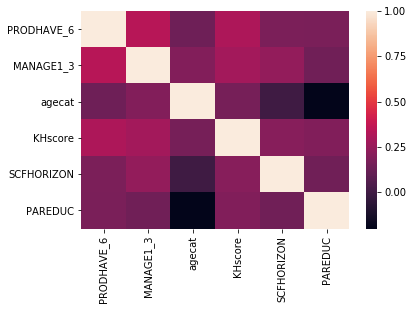

In [34]:
%matplotlib inline

#Correlation matrix
corr = dfx_3.corr(method='spearman')

#Heatmap
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns)

Now that we have these 6 variables, we can also look their visualizations.

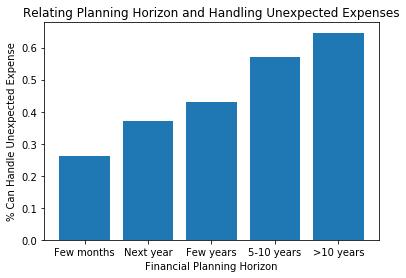

In [6]:
#Remove rows where response was -1 (no response)
dfhorizon = df[df['SCFHORIZON'] != -1]

#Create table containing relevant values
horizon_tab = pd.crosstab(dfhorizon['SCFHORIZON'], dfhorizon['target'])

#Create x and y values to graph
x_vals = np.arange(5) + 1
x_labels = ['Few months', 'Next year', 'Few years', '5-10 years', '>10 years']
horizon_vals = np.empty(5)
for i in range(5):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    horizon_vals[i] = horizon_tab.loc[i+1, True] / np.sum(horizon_tab.iloc[i, 0:2])

#Create bar graph 
plt.bar(x_vals, horizon_vals)
plt.title('Relating Planning Horizon and Handling Unexpected Expenses')
plt.xlabel('Financial Planning Horizon')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels)
plt.show()

In [15]:
chi, p_val, dof, expected = chi2_contingency(horizon_tab)

print('p-val: {}'.format(p_val))

p-val: 1.3372684573812833e-34


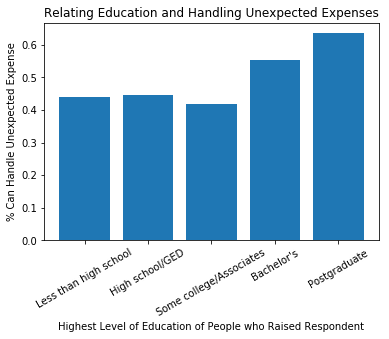

In [12]:
#Remove rows where response was -1 (no response)
dfeducation = df[df['PAREDUC'] != -1]

#Create table with relevant values
education_tab = pd.crosstab(dfeducation['PAREDUC'], df['target'])

#Create x and y values to graph
x_vals = np.arange(5) + 1
x_labels = ['Less than high school', 'High school/GED', 'Some college/Associates', 'Bachelor\'s', 'Postgraduate']
education_vals = np.empty(5)
for i in range(5):
    #Calculate percentage of respondents who responded True for target variable, grouped by response
    education_vals[i] = education_tab.iloc[i, 1] / np.sum(education_tab.iloc[i, 0:2])

#Create bar graph
plt.bar(x_vals, education_vals)
plt.title('Relating Education and Handling Unexpected Expenses')
plt.xlabel('Highest Level of Education of People who Raised Respondent')
plt.ylabel('% Can Handle Unexpected Expense')
plt.xticks(x_vals, x_labels, rotation=30)
plt.show()

In [13]:
chi, p_val, dof, expected = chi2_contingency(education_tab)

print('p-val: {}'.format(p_val))

p-val: 1.7768030196282957e-15


Both our graphical and quantitative analyses confirm that these two variables are good predictors of our target variable. 